# Imports

In [31]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import itertools
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs, nsdiffs
import pmdarima as pm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
# set random seed
SEED = 321
np.random.seed(SEED)

sns.set_context('notebook', font_scale=1.2)
plt.rcParams['figure.figsize']=(12,3)


# Custom Functions

In [2]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

In [3]:
def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [4]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [5]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)

    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')

    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )

    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)



    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 

        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")

    fig.tight_layout()
    
    return fig

# Prepare Data for Modeling

In [6]:
#glob all data together
f = "Data/Chicago-Crime*.csv"
crime_data = sorted(glob.glob(f))
crime_data

['Data\\Chicago-Crime_2001.csv',
 'Data\\Chicago-Crime_2002.csv',
 'Data\\Chicago-Crime_2003.csv',
 'Data\\Chicago-Crime_2004.csv',
 'Data\\Chicago-Crime_2005.csv',
 'Data\\Chicago-Crime_2006.csv',
 'Data\\Chicago-Crime_2007.csv',
 'Data\\Chicago-Crime_2008.csv',
 'Data\\Chicago-Crime_2009.csv',
 'Data\\Chicago-Crime_2010.csv',
 'Data\\Chicago-Crime_2011.csv',
 'Data\\Chicago-Crime_2012.csv',
 'Data\\Chicago-Crime_2013.csv',
 'Data\\Chicago-Crime_2014.csv',
 'Data\\Chicago-Crime_2015.csv',
 'Data\\Chicago-Crime_2016.csv',
 'Data\\Chicago-Crime_2017.csv',
 'Data\\Chicago-Crime_2018.csv',
 'Data\\Chicago-Crime_2019.csv',
 'Data\\Chicago-Crime_2020.csv',
 'Data\\Chicago-Crime_2021.csv',
 'Data\\Chicago-Crime_2022.csv']

In [7]:
#create main df
df = pd.concat([pd.read_csv(f, lineterminator='\n') for f in crime_data])
df

,ID,Date,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
0,1326041,01/01/2001 01:00:00 AM,BATTERY,SIMPLE,RESIDENCE,False,False,1624,16.0,NaN,41.957850,-87.749185
1,1319931,01/01/2001 01:00:00 PM,BATTERY,SIMPLE,RESIDENCE,False,True,825,8.0,NaN,41.783892,-87.684841
2,1324743,01/01/2001 01:00:00 PM,GAMBLING,ILLEGAL ILL LOTTERY,STREET,True,False,313,3.0,NaN,41.780412,-87.611970
3,1310717,01/01/2001 01:00:00 AM,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,2424,24.0,NaN,42.012391,-87.678032
4,1318099,01/01/2001 01:00:00 AM,BATTERY,SIMPLE,RESIDENCE PORCH/HALLWAY,False,True,214,2.0,NaN,41.819538,-87.620020
...,...,...,...,...,...,...,...,...,...,...,...,...
238853,12938029,12/31/2022 12:50:00 PM,ASSAULT,SIMPLE,APARTMENT,False,False,1014,10.0,24.0,41.855911,-87.719966
238854,12937822,12/31/2022 12:50:00 PM,ASSAULT,AGGRAVATED - HANDGUN,APARTMENT,False,True,733,7.0,6.0,41.766546,-87.645669
238855,12937583,12/31/2022 12:52:00 AM,BATTERY,SIMPLE,BARBERSHOP,False,False,1135,11.0,28.0,41.868829,-87.686098
238856,12938420,12/31/2022 12:52:00 PM,ASSAULT,SIMPLE,COMMERCIAL / BUSINESS OFFICE,False,False,1432,14.0,32.0,41.930693,-87.685657


In [8]:
#change datatype of date to datetime
df['Date'] = pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7713109 entries, 0 to 238857
Data columns (total 12 columns):
 #   Column                Dtype         
---  ------                -----         
 0   ID                    int64         
 1   Date                  datetime64[ns]
 2   Primary Type          object        
 3   Description           object        
 4   Location Description  object        
 5   Arrest                bool          
 6   Domestic              bool          
 7   Beat                  int64         
 8   District              float64       
 9   Ward                  float64       
 10  Latitude              float64       
 11  Longitude             float64       
dtypes: bool(2), datetime64[ns](1), float64(4), int64(2), object(3)
memory usage: 662.0+ MB


In [9]:
#set primary type as index to create a new dataframe to create new dataframes for assault and narcotics
df = df.set_index('Primary Type')
df

,ID,Date,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
Primary Type,,,,,,,,,,,
BATTERY,1326041,2001-01-01 01:00:00,SIMPLE,RESIDENCE,False,False,1624,16.0,NaN,41.957850,-87.749185
BATTERY,1319931,2001-01-01 13:00:00,SIMPLE,RESIDENCE,False,True,825,8.0,NaN,41.783892,-87.684841
GAMBLING,1324743,2001-01-01 13:00:00,ILLEGAL ILL LOTTERY,STREET,True,False,313,3.0,NaN,41.780412,-87.611970
CRIMINAL DAMAGE,1310717,2001-01-01 01:00:00,TO VEHICLE,STREET,False,False,2424,24.0,NaN,42.012391,-87.678032
BATTERY,1318099,2001-01-01 01:00:00,SIMPLE,RESIDENCE PORCH/HALLWAY,False,True,214,2.0,NaN,41.819538,-87.620020
...,...,...,...,...,...,...,...,...,...,...,...
ASSAULT,12938029,2022-12-31 12:50:00,SIMPLE,APARTMENT,False,False,1014,10.0,24.0,41.855911,-87.719966
ASSAULT,12937822,2022-12-31 12:50:00,AGGRAVATED - HANDGUN,APARTMENT,False,True,733,7.0,6.0,41.766546,-87.645669
BATTERY,12937583,2022-12-31 00:52:00,SIMPLE,BARBERSHOP,False,False,1135,11.0,28.0,41.868829,-87.686098


In [10]:
#drop unnecessary columns
df = df.drop(['ID', 'Description', 'Location Description', 'Domestic', 'Beat', 'District', 
             'Ward', 'Latitude', 'Longitude'], axis=1)
df.head()

,Date,Arrest
Primary Type,,
BATTERY,2001-01-01 01:00:00,False
BATTERY,2001-01-01 13:00:00,False
GAMBLING,2001-01-01 13:00:00,True
CRIMINAL DAMAGE,2001-01-01 01:00:00,False
BATTERY,2001-01-01 01:00:00,False


In [11]:
#create new dataframe for assault
assault = df.loc['ASSAULT'].copy()
assault

,Date,Arrest
Primary Type,,
ASSAULT,2001-01-01 01:00:00,False
ASSAULT,2001-01-01 13:00:00,True
ASSAULT,2001-01-01 13:00:00,False
ASSAULT,2001-01-01 01:02:29,False
ASSAULT,2001-01-01 01:07:38,True
...,...,...
ASSAULT,2022-12-31 12:38:00,False
ASSAULT,2022-12-31 00:41:00,False
ASSAULT,2022-12-31 12:50:00,False


In [12]:
#create a new dataframe for narcotics
narcotics = df.loc['NARCOTICS'].copy()
narcotics

,Date,Arrest
Primary Type,,
NARCOTICS,2001-01-01 13:00:00,True
NARCOTICS,2001-01-01 13:10:00,True
NARCOTICS,2001-01-01 13:10:00,True
NARCOTICS,2001-01-01 01:12:00,True
NARCOTICS,2001-01-01 13:20:00,True
...,...,...
NARCOTICS,2022-12-31 15:37:00,True
NARCOTICS,2022-12-31 16:20:00,True
NARCOTICS,2022-12-31 17:03:00,True


# Assault Model

In [13]:
#set date as index
assault = assault.set_index('Date')
assault.head()

,Arrest
Date,
2001-01-01 01:00:00,False
2001-01-01 13:00:00,True
2001-01-01 13:00:00,False
2001-01-01 01:02:29,False
2001-01-01 01:07:38,True


In [14]:
# Resample to monthly
assault = assault.resample("M").sum()
assault.head()

,Arrest
Date,
2001-01-31,515
2001-02-28,501
2001-03-31,631
2001-04-30,639
2001-05-31,638


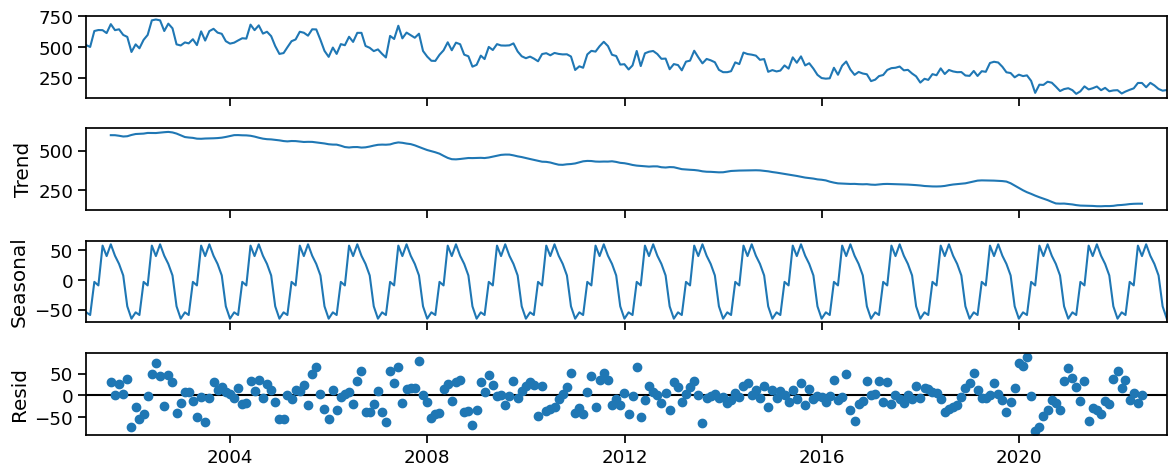

In [15]:
# Apply seasonal decomposition to check for seasonality
decomp = tsa.seasonal_decompose(assault)
fig = decomp.plot()
fig.set_size_inches(12,5)
fig.tight_layout()

In [20]:
# How big is the seasonal component
seasonal_delta = decomp.seasonal.max() - decomp.seasonal.min()

# How big is the seasonal component relative to the time series?
print(f"The seasonal component is {seasonal_delta} which is ~{seasonal_delta/float(assault.max()-assault.min())* 100:.2f}% of the variation in time series.") 

The seasonal component is 125.46230158730162 which is ~20.67% of the variation in time series.


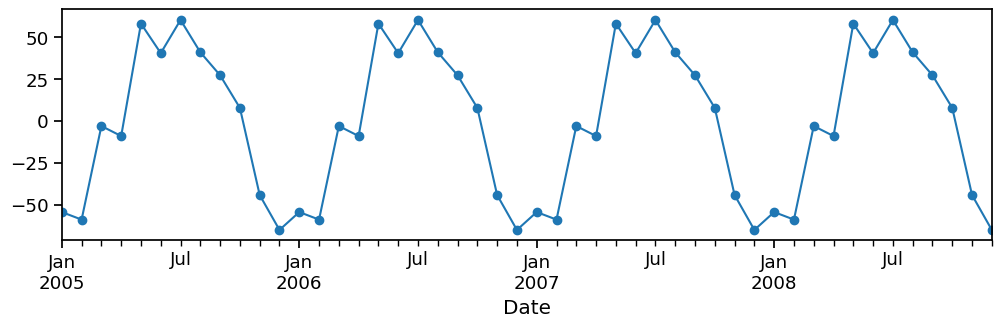

In [23]:
#plot the time series to see the seasonality
seasonal = decomp.seasonal
ax = seasonal.loc['2005': '2008'].plot(marker = 'o')

In [32]:
# Check for stationarity
get_adfuller_results(assault)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-0.315153,14,249,0.923331,0.05,False


In [24]:
#determine nonseasonal differencing
# determine d
d = ndiffs(assault)
print (f'd = {d}')

d = 1


In [25]:
#determine seasonal differencing
# Determine D
D = nsdiffs(assault, m =12)
print(f'D = {D}')

D = 0


In [26]:
#difference the data
assault_diff = assault.diff().dropna()

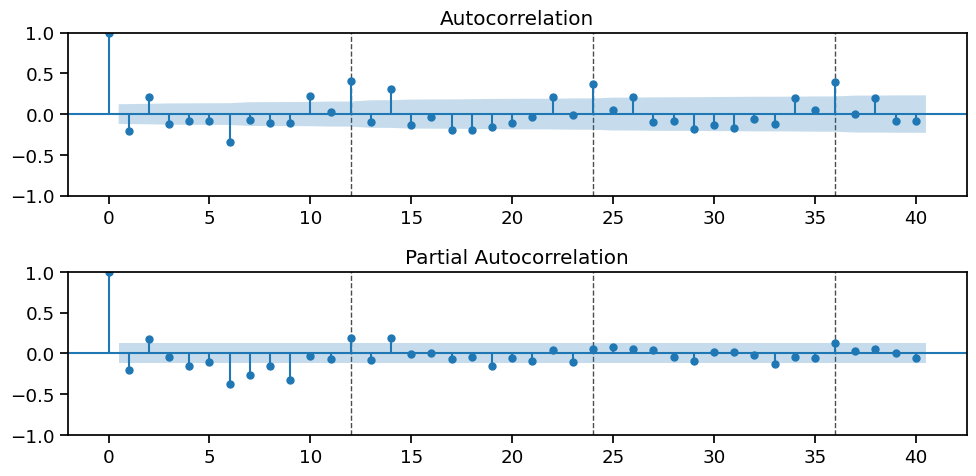

In [27]:
#find the acf and pacf
plot_acf_pacf(assault_diff, annotate_seas=True, m=12);

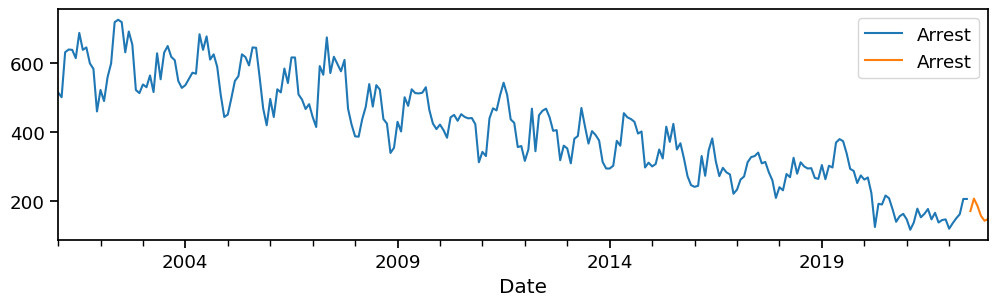

In [75]:
#test train split
atrain, atest = train_test_split(assault, test_size=6)
ax = atrain.plot(label='Train')
atest.plot(ax=ax, label='Test')
ax.legend();

In [76]:
# Orders for non seasonal components
p = 1  # nonseasonal AR
d = 1  # nonseasonal differencing
q = 1  # nonseasonal MA

# Orders for seasonal components
P = 1  # Seasonal AR
D = 0  # Seasonal differencing
Q = 0  # Seasonal MA
m = 12 # Seasonal period

sarima = tsa.ARIMA(atrain, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 17.053
- MSE = 397.756
- RMSE = 19.944
- R^2 = 0.204
- MAPE = 9.84%


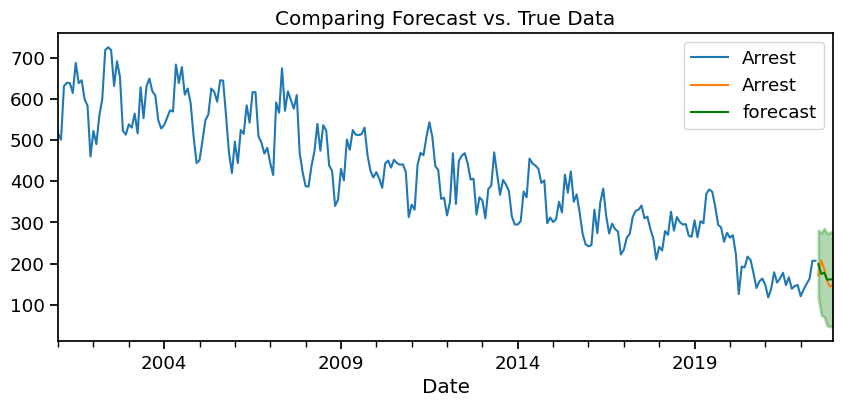

In [77]:
# Obtain summary of forecast as dataframe
aforecast_df = sarima.get_forecast(len(atest)).summary_frame()
# Plot the forecast with true values
plot_forecast(atrain, atest, aforecast_df)
# Obtain metrics
regression_metrics_ts(atest, aforecast_df["mean"])

In [78]:
# Default auto_arima will select model based on AIC score
auto_model = pm.auto_arima(
    atrain,
    seasonal=True,  
    m=12,
    trace=True
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.77 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2744.918, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2680.163, Time=0.18 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2702.055, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2743.065, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=2736.245, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=2657.938, Time=0.56 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=2621.146, Time=0.93 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=2620.505, Time=0.31 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=2700.914, Time=0.12 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=2620.729, Time=0.88 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=2689.374, Time=0.37 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=1.29 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=2646.501, Time=0.19 sec
 ARIMA(2,1,0)(1,0,1)[12] inte

In [34]:
# Obtain summary of the best model from auto_arima
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  258
Model:             SARIMAX(5, 1, 3)x(1, 0, [1, 2], 12)   Log Likelihood               -1283.625
Date:                                 Wed, 01 Nov 2023   AIC                           2591.250
Time:                                         14:41:32   BIC                           2633.839
Sample:                                     01-31-2001   HQIC                          2608.378
                                          - 06-30-2022                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1777      0.121     -9.765      0.000      -1.414      -0.941
ar.L2          0.0903      0.128      0.704      0.481      -0.161       0.341
ar.L3          0.6508      0.142      4.585      0.000       0.373       0.929
ar.L4          0.2171      0.121      1.798      0.072      -0.020       0.454
ar.L5          0.1295      0.084      1.544      0.123      -0.035       0.294
ma.L1          0.7267      0.114      6.356      0.000       0.503       0.951
ma.L2         -0.7898      0.058    -13.575      0.000      -0.904      -0.676
ma.L3         -0.8111      0.099     -8.174      0.000      -1.006      -0.617
ar.S.L12       0.9794      0.011     86.554      0.000       0.957       1.002
ma.S.L12      -0.9304      0.082    -11.395      0.000      -1.090      -0.770
ma.S.L24       0.1722      0.088      1.953      0.051      -0.001       0.345
sigma2      1179.1762     97.357     12.112      0.000     988.360    1369.992
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 8.51
Prob(Q):                              0.84   Prob(JB):                         0.01
Heteroskedasticity (H):               0.70   Skew:                            -0.31
Prob(H) (two-sided):                  0.09   Kurtosis:                         3.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

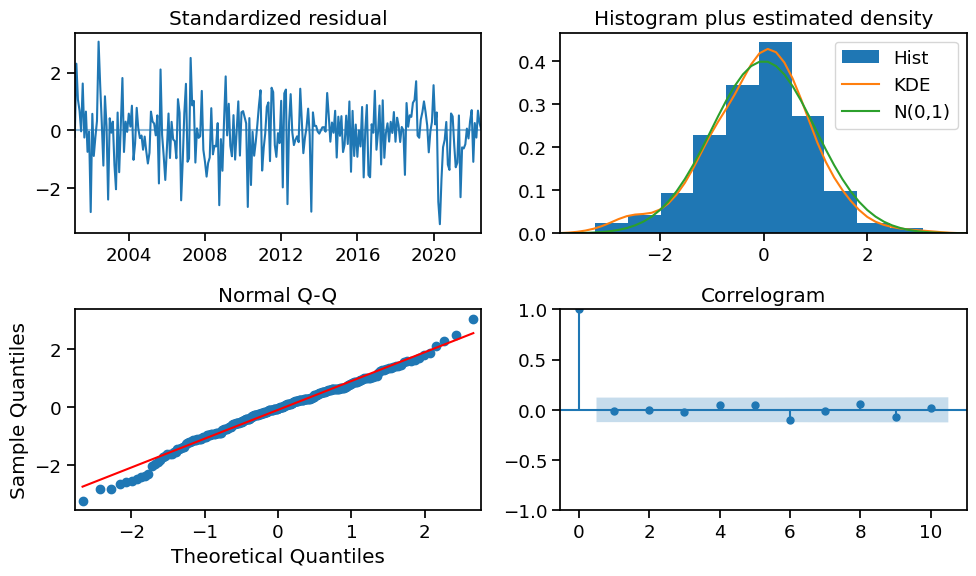

In [35]:
# Obtain diagnostic plots
fig = auto_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

C:\Users\17175\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\17175\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\17175\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 16.990
- MSE = 410.409
- RMSE = 20.259
- R^2 = 0.178
- MAPE = 9.94%


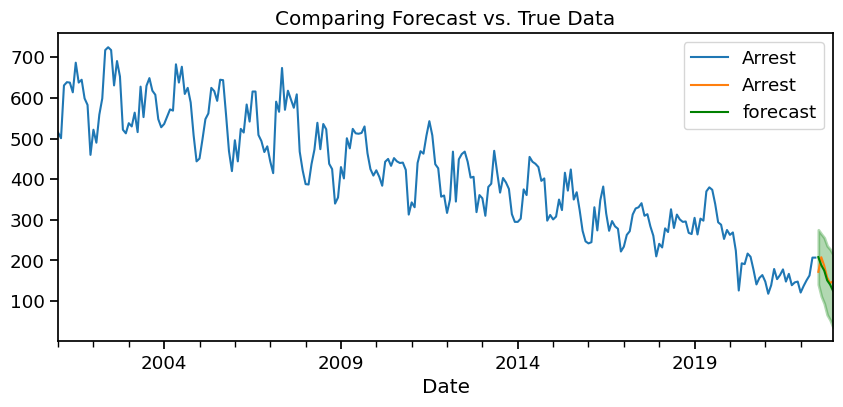

In [79]:
# Use auto_arima parameters to fit an ARIMA
auto_model = tsa.ARIMA(
    atrain, order=auto_model.order, seasonal_order=auto_model.seasonal_order
).fit()


# Obtain forecast as a dataframe with confidence intervals
aforecast_df = auto_model.get_forecast(steps=len(atest)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(atrain, atest, aforecast_df);
# Obtain metrics
regression_metrics_ts(atest, aforecast_df['mean'])

#### I will be using the first model as almost all of the metrics did slightly better than the second one.

In [81]:
# These are the parameters of our final model
# Orders for non seasonal components
p = 1  # nonseasonal AR
d = 1  # nonseasonal differencing
q = 1  # nonseasonal MA

# Orders for seasonal components
P = 1  # Seasonal AR
D = 0  # Seasonal differencing
Q = 0  # Seasonal MA
m = 12 # Seasonal period

final_model = tsa.ARIMA(assault, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

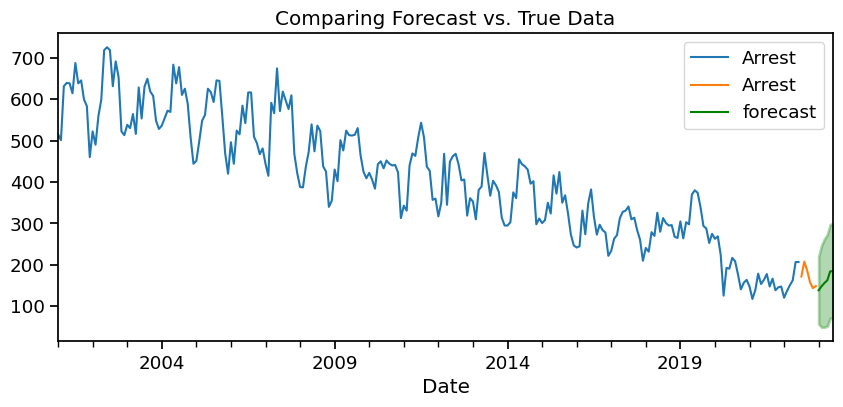

In [82]:
# Obtain future forecasts beyond test data
aforecast_df  = final_model.get_forecast(len(atest)).summary_frame()
plot_forecast(atrain,atest,aforecast_df);

In [83]:
#find the starting and end dates of the forecast
aforecast_df.index[0],aforecast_df.index[-1]

(Timestamp('2023-01-31 00:00:00', freq='M'),
 Timestamp('2023-06-30 00:00:00', freq='M'))

In [84]:
#define the starting value of the forecast
starting_value = aforecast_df['mean'].iloc[0]
starting_value

138.89917769658487

In [85]:
#define the final value of the forecast
final_value = aforecast_df['mean'].iloc[-1]
final_value

184.85690246200863

In [86]:
#define the change in values
change = final_value - starting_value
change

45.95772476542376

In [44]:
#calculate this change as a percentage
perc_change = (change / starting_value) * 100
perc_change

33.08711075728257

# Narcotics Model

In [45]:
#set date as index
narcotics = narcotics.set_index('Date')
narcotics.head()

,Arrest
Date,
2001-01-01 13:00:00,True
2001-01-01 13:10:00,True
2001-01-01 13:10:00,True
2001-01-01 01:12:00,True
2001-01-01 13:20:00,True


In [46]:
# Resample to monthly
narcotics = narcotics.resample("M").sum()
narcotics.head()

,Arrest
Date,
2001-01-31,4714
2001-02-28,4369
2001-03-31,4861
2001-04-30,4043
2001-05-31,4038


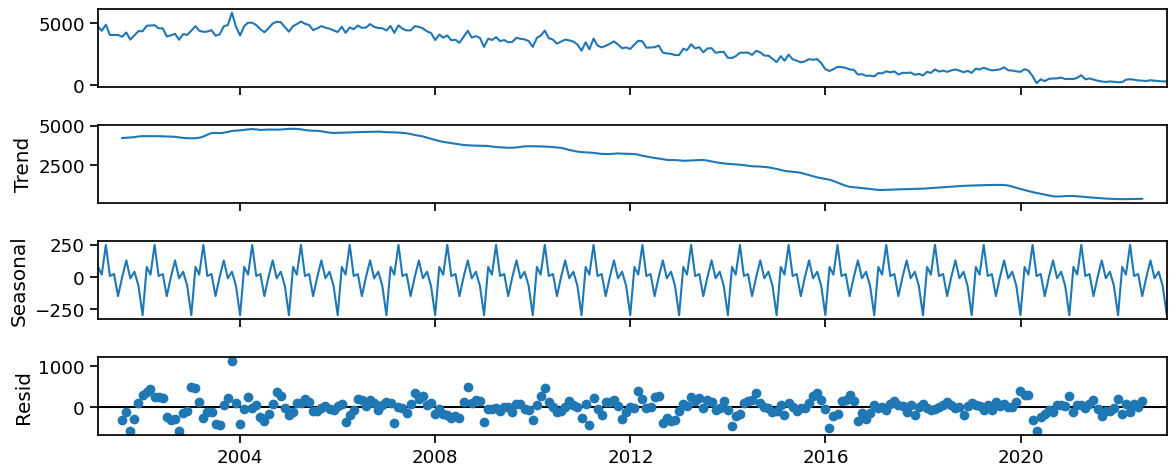

In [47]:
# Apply seasonal decomposition to check for seasonality
decomp = tsa.seasonal_decompose(narcotics)
fig = decomp.plot()
fig.set_size_inches(12,5)
fig.tight_layout()

In [48]:
# How big is the seasonal component
seasonal_delta = decomp.seasonal.max() - decomp.seasonal.min()

# How big is the seasonal component relative to the time series?
print(f"The seasonal component is {seasonal_delta} which is ~{seasonal_delta/float(assault.max()-assault.min())* 100:.2f}% of the variation in time series.")

The seasonal component is 547.0079365079364 which is ~90.12% of the variation in time series.


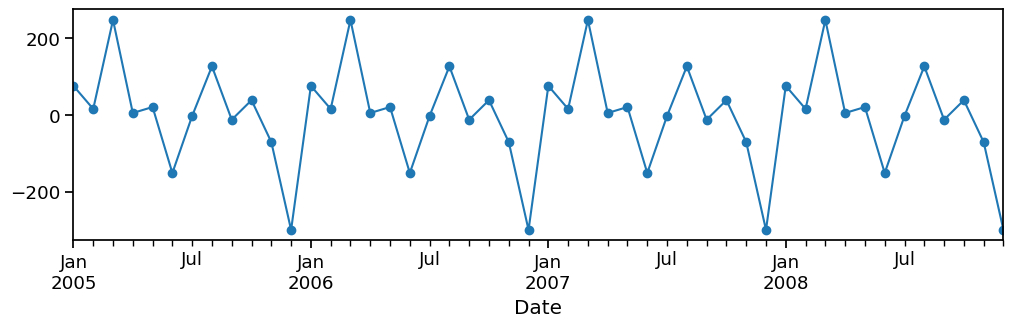

In [49]:
#plot the time series to see the seasonality
seasonal = decomp.seasonal
ax = seasonal.loc['2005': '2008'].plot(marker = 'o')

In [50]:
# Check for stationarity
get_adfuller_results(narcotics)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,0.273702,12,251,0.976105,0.05,False


In [51]:
# determine d
d = ndiffs(narcotics)
print (f'd = {d}')
# determine D
D = nsdiffs(narcotics, m = 12)
print (f'D = {D}')

d = 1
D = 0


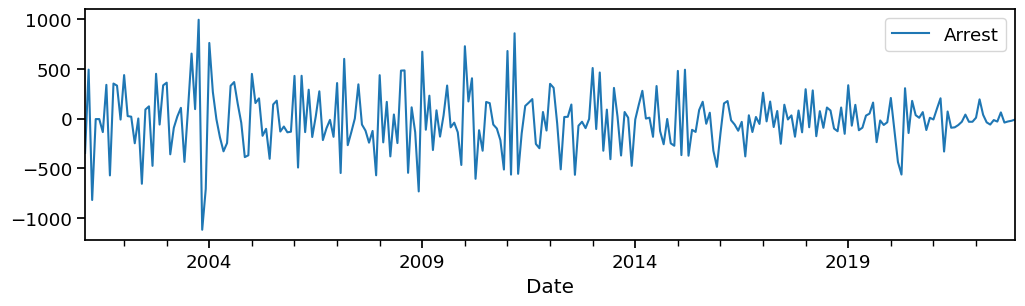

In [52]:
#apply the differencing
n_diff = narcotics.diff().dropna()
n_diff.plot();

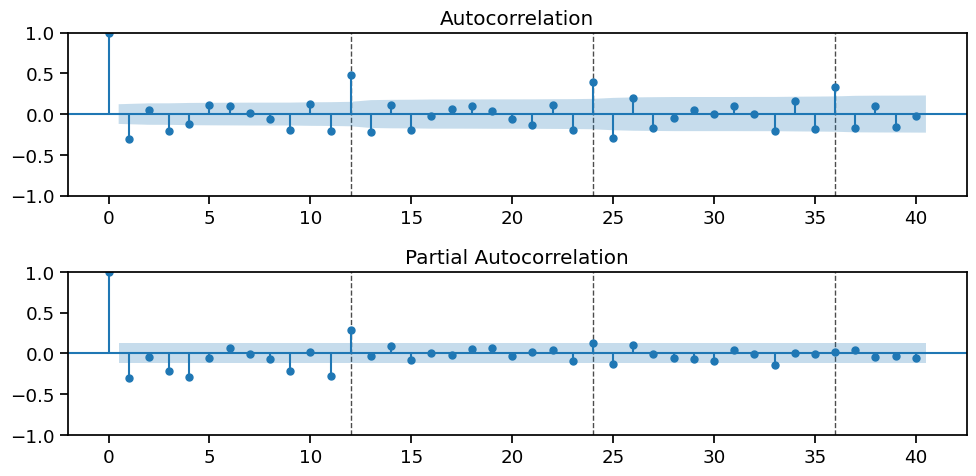

In [53]:
# now look at the acf/pacf of the stationary data
plot_acf_pacf(n_diff, annotate_seas = True, m = 12);

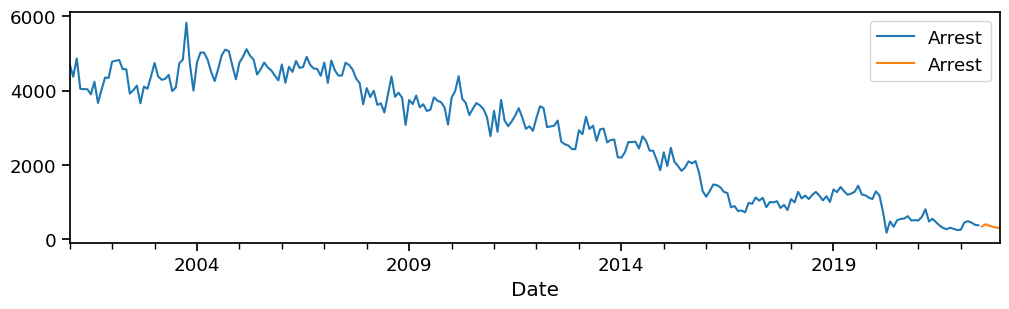

In [54]:
# tts
train, test = train_test_split(narcotics, test_size=6)
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

In [55]:
# Orders for non seasonal components
p = 1  # nonseasonal AR
d = 1  # nonseasonal differencing
q = 1  # nonseasonal MA

# Orders for seasonal components
P = 1  # Seasonal AR
D = 0  # Seasonal differencing
Q = 1  # Seasonal MA
m = 12 # Seasonal period

sarima = tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

# Obtain summary
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                           Arrest   No. Observations:                  258
Model:             ARIMA(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -1764.587
Date:                          Wed, 01 Nov 2023   AIC                           3539.173
Time:                                  15:05:05   BIC                           3556.919
Sample:                              01-31-2001   HQIC                          3546.310
                                   - 06-30-2022                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5690      0.085      6.688      0.000       0.402       0.736
ma.L1         -0.8411      0.067    -12.621      0.000      -0.972      -0.711
ar.S.L12       0.9480      0.027     35.343      0.000       0.895       1.001
ma.S.L12      -0.7377      0.075     -9.799      0.000      -0.885      -0.590
sigma2      5.269e+04   3467.683     15.194      0.000    4.59e+04    5.95e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                45.23
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               0.36   Skew:                            -0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

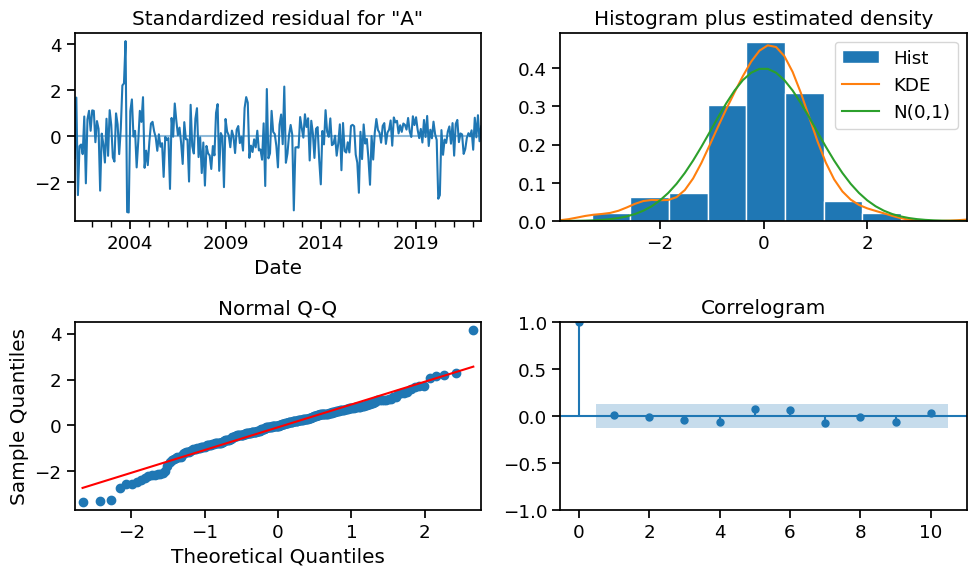

In [56]:
# Obtain diagnostic plots
fig = sarima.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 74.804
- MSE = 7,085.888
- RMSE = 84.178
- R^2 = -5.322
- MAPE = 22.39%


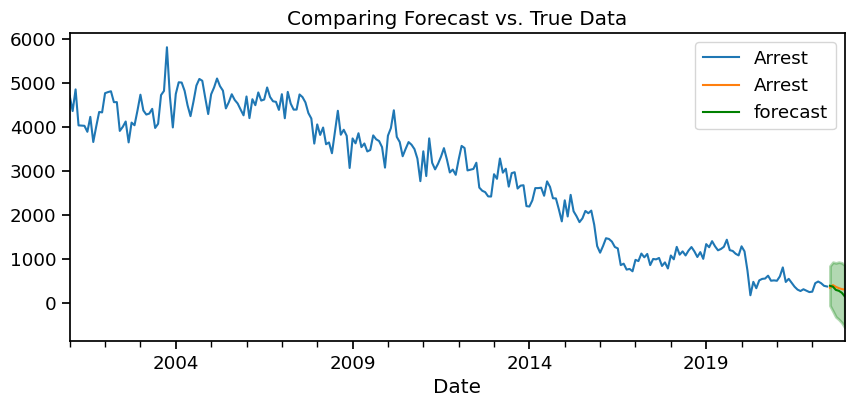

In [57]:
# Obtain forecast as a dataframe with confidence intervals
forecast_df = sarima.get_forecast(steps=len(test)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train, test, forecast_df);
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

In [58]:
# Default auto_arima will select model based on AIC score
auto_model = pm.auto_arima(
    train,
    seasonal=True,  
    m=12,
    trace=True
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3664.391, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3582.263, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3594.187, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3663.206, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=3640.515, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=3575.501, Time=0.73 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=3557.860, Time=1.18 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=3557.806, Time=0.36 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=3600.789, Time=0.15 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=3557.607, Time=1.42 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=3588.142, Time=0.45 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=1.32 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=3564.517, Time=1.23 sec
 ARIMA(2,1,0)(1,0,2)[12] inte

In [59]:
# Obtain summary of the best model from auto_arima
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  258
Model:             SARIMAX(4, 1, 0)x(1, 0, [1], 12)   Log Likelihood               -1763.835
Date:                              Wed, 01 Nov 2023   AIC                           3541.669
Time:                                      15:08:03   BIC                           3566.513
Sample:                                  01-31-2001   HQIC                          3551.660
                                       - 06-30-2022                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2481      0.042     -5.890      0.000      -0.331      -0.166
ar.L2         -0.1799      0.052     -3.476      0.001      -0.281      -0.078
ar.L3         -0.2041      0.059     -3.481      0.000      -0.319      -0.089
ar.L4         -0.1958      0.061     -3.230      0.001      -0.315      -0.077
ar.S.L12       0.9393      0.031     30.103      0.000       0.878       1.000
ma.S.L12      -0.7264      0.080     -9.104      0.000      -0.883      -0.570
sigma2      5.265e+04   3668.908     14.350      0.000    4.55e+04    5.98e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                38.96
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.33   Skew:                            -0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

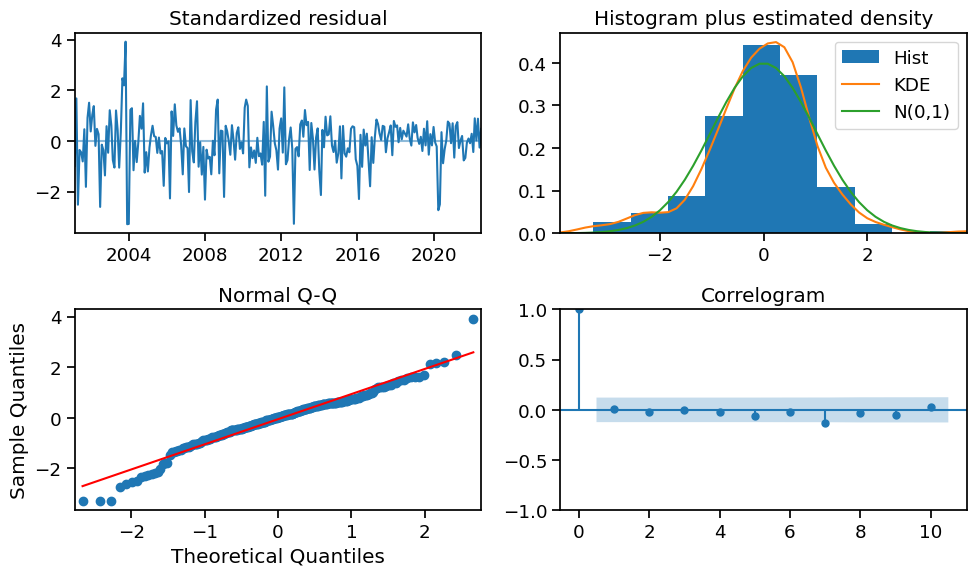

In [60]:
# Obtain diagnostic plots
fig = auto_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 36.753
- MSE = 1,984.216
- RMSE = 44.545
- R^2 = -0.770
- MAPE = 10.95%


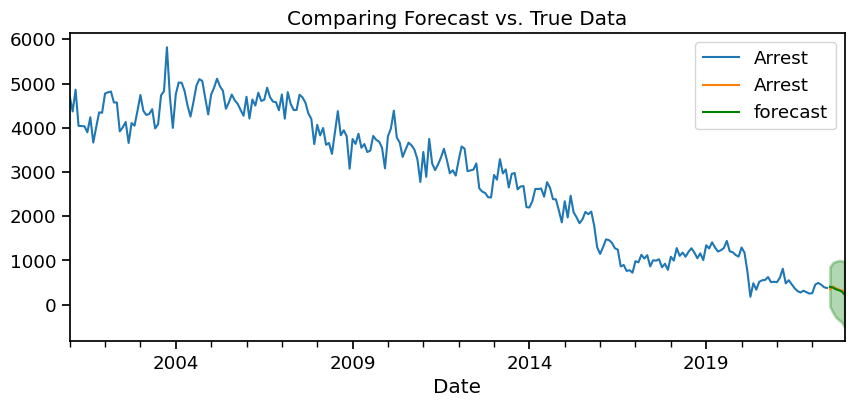

In [61]:
# Use auto_arima parameters to fit an ARIMA
auto_model = tsa.ARIMA(
    train, order=auto_model.order, seasonal_order=auto_model.seasonal_order
).fit()


# Obtain forecast as a dataframe with confidence intervals
forecast_df = auto_model.get_forecast(steps=len(test)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train, test, forecast_df);
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

#### I will be using the second model as my final model as the metrics did much better than the first model

In [62]:
# These are the parameters of our final model
# Orders for non seasonal components
p = 4  # nonseasonal AR
d = 1  # nonseasonal differencing
q = 0  # nonseasonal MA

# Orders for seasonal components
P = 1  # Seasonal AR
D = 0  # Seasonal differencing
Q = 1  # Seasonal MA
m = 12 # Seasonal period

final_model = tsa.ARIMA(narcotics, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

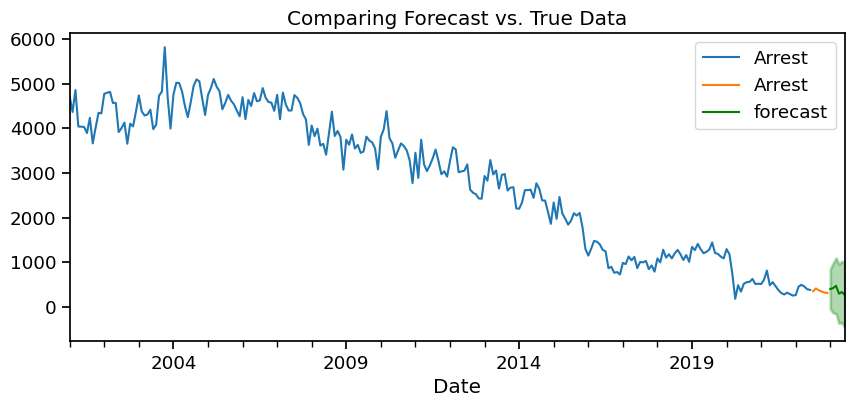

In [63]:
# Obtain future forecasts beyond test data
forecast_df  = final_model.get_forecast(len(test)).summary_frame()
plot_forecast(train,test,forecast_df);

In [64]:
#find the starting and ending dates of the forecast
forecast_df.index[0],forecast_df.index[-1]

(Timestamp('2023-01-31 00:00:00', freq='M'),
 Timestamp('2023-06-30 00:00:00', freq='M'))

In [65]:
#define the starting value of the forecast
starting_value = forecast_df['mean'].iloc[0]
starting_value

398.2895525715328

In [66]:
#defien the ending value of the forecast
final_value = forecast_df['mean'].iloc[-1]
final_value

266.87657868557534

In [67]:
#calculate the change in values
change = final_value - starting_value
change

-131.41297388595746

In [69]:
#calculate the change as a percentage
perc_change = (change / starting_value) * 100
perc_change

-32.99433114363593

# Final Evaluation

## Of the two crimes, which is forecasted to have the highest monthly count of crimes at the end of the forecast?
- At the end of the forecast narcotics has the highest count of crimes

## Of the two crimes, which is forecasted to have the highest net change by the end of the forecast?
- By the end of the forecast narcotics has the highest net change

## Of the two crimes, which is forecasted to have the highest percent change by the end of the forecast?
- By the end of the forecast assault has the highest percent change

# Stakeholder Questions

## What recommendation would you make to the stakeholders?
- I recommend keeping current resources on narcotics crimes as it is forecasted to go down by by 32% over the next six months and to allocate more resources toward assault crimes as it is forecasted to go up by 33% over the next six months

## Include reporting-quality visual(s) to support your recommendation.

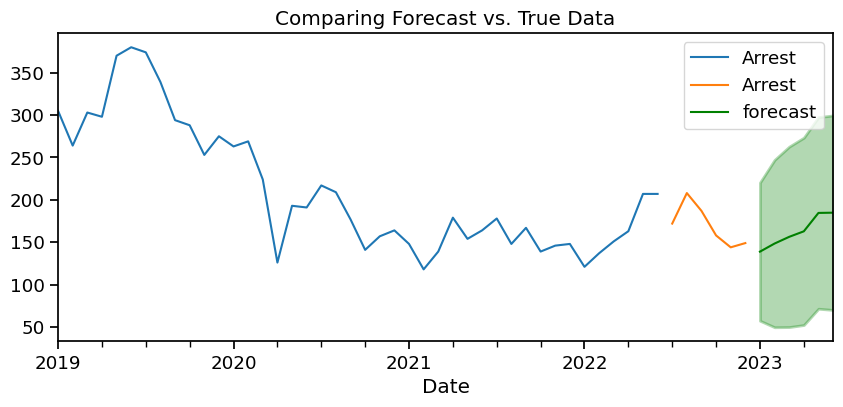

In [87]:
plot_forecast(atrain.loc['2019':],atest,aforecast_df);

### In the above visual we see that assault crimes are going up in the forecast.

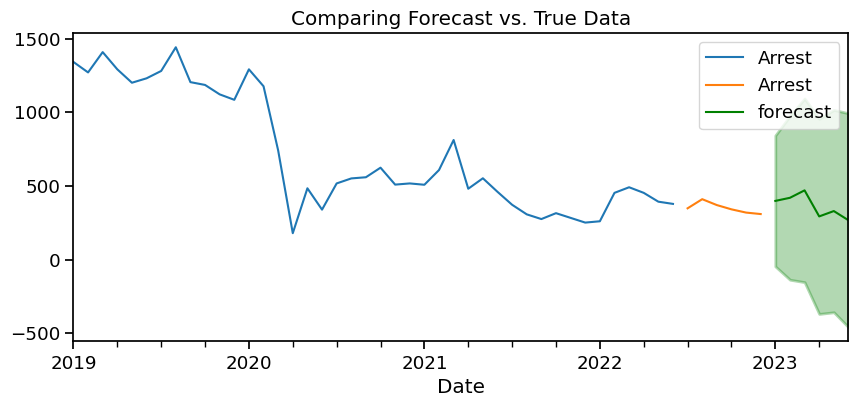

In [74]:
plot_forecast(train.loc['2019':],test,forecast_df);

### In the above visual we can see Narcotics crimes going down in the forecast